# Energy resolution after fidutials

## DEMO Run8


### April 2021, JAH

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy             as np
import pandas            as pd
import tables            as tb
import matplotlib.pyplot as plt

In [3]:
import hipy.utils        as ut
import hipy.pltext       as pltext

import next.core.io        as nio
import next.core.selection as nsel

import next.eres.eres      as eres

In [4]:
pltext.style()

import warnings
warnings.filterwarnings('ignore')

import time
print(' Last revision ', time.asctime())

 Last revision  Fri Apr 16 13:09:30 2021


### load data

In [5]:
filename  = f'/home/hernando/data/demo/run8/dfesme_fidutial_combined.h5'
dft       = pd.read_hdf(filename, 'esme')
print('total number of events ', len(dft))

total number of events  1828937


### Inspect DF

['event', 'trackID', 'energy', 'length', 'numb_of_voxels', 'numb_of_hits', 'numb_of_tracks', 'x_min', 'y_min', 'z_min', 'r_min', 'x_max', 'y_max', 'z_max', 'r_max', 'x_ave', 'y_ave', 'z_ave', 'r_ave', 'extreme1_x', 'extreme1_y', 'extreme1_z', 'extreme2_x', 'extreme2_y', 'extreme2_z', 'blob1_x', 'blob1_y', 'blob1_z', 'blob2_x', 'blob2_y', 'blob2_z', 'eblob1', 'eblob2', 'ovlp_blob_energy', 'dz_track', 'enecor', 'time', 'nS2', 'S1e', 'S2e', 'S2q', 'Nsipm', 'evt_energy', 'evt_ntrks', 'evt_nhits', 'evt_out_of_map', 'run']


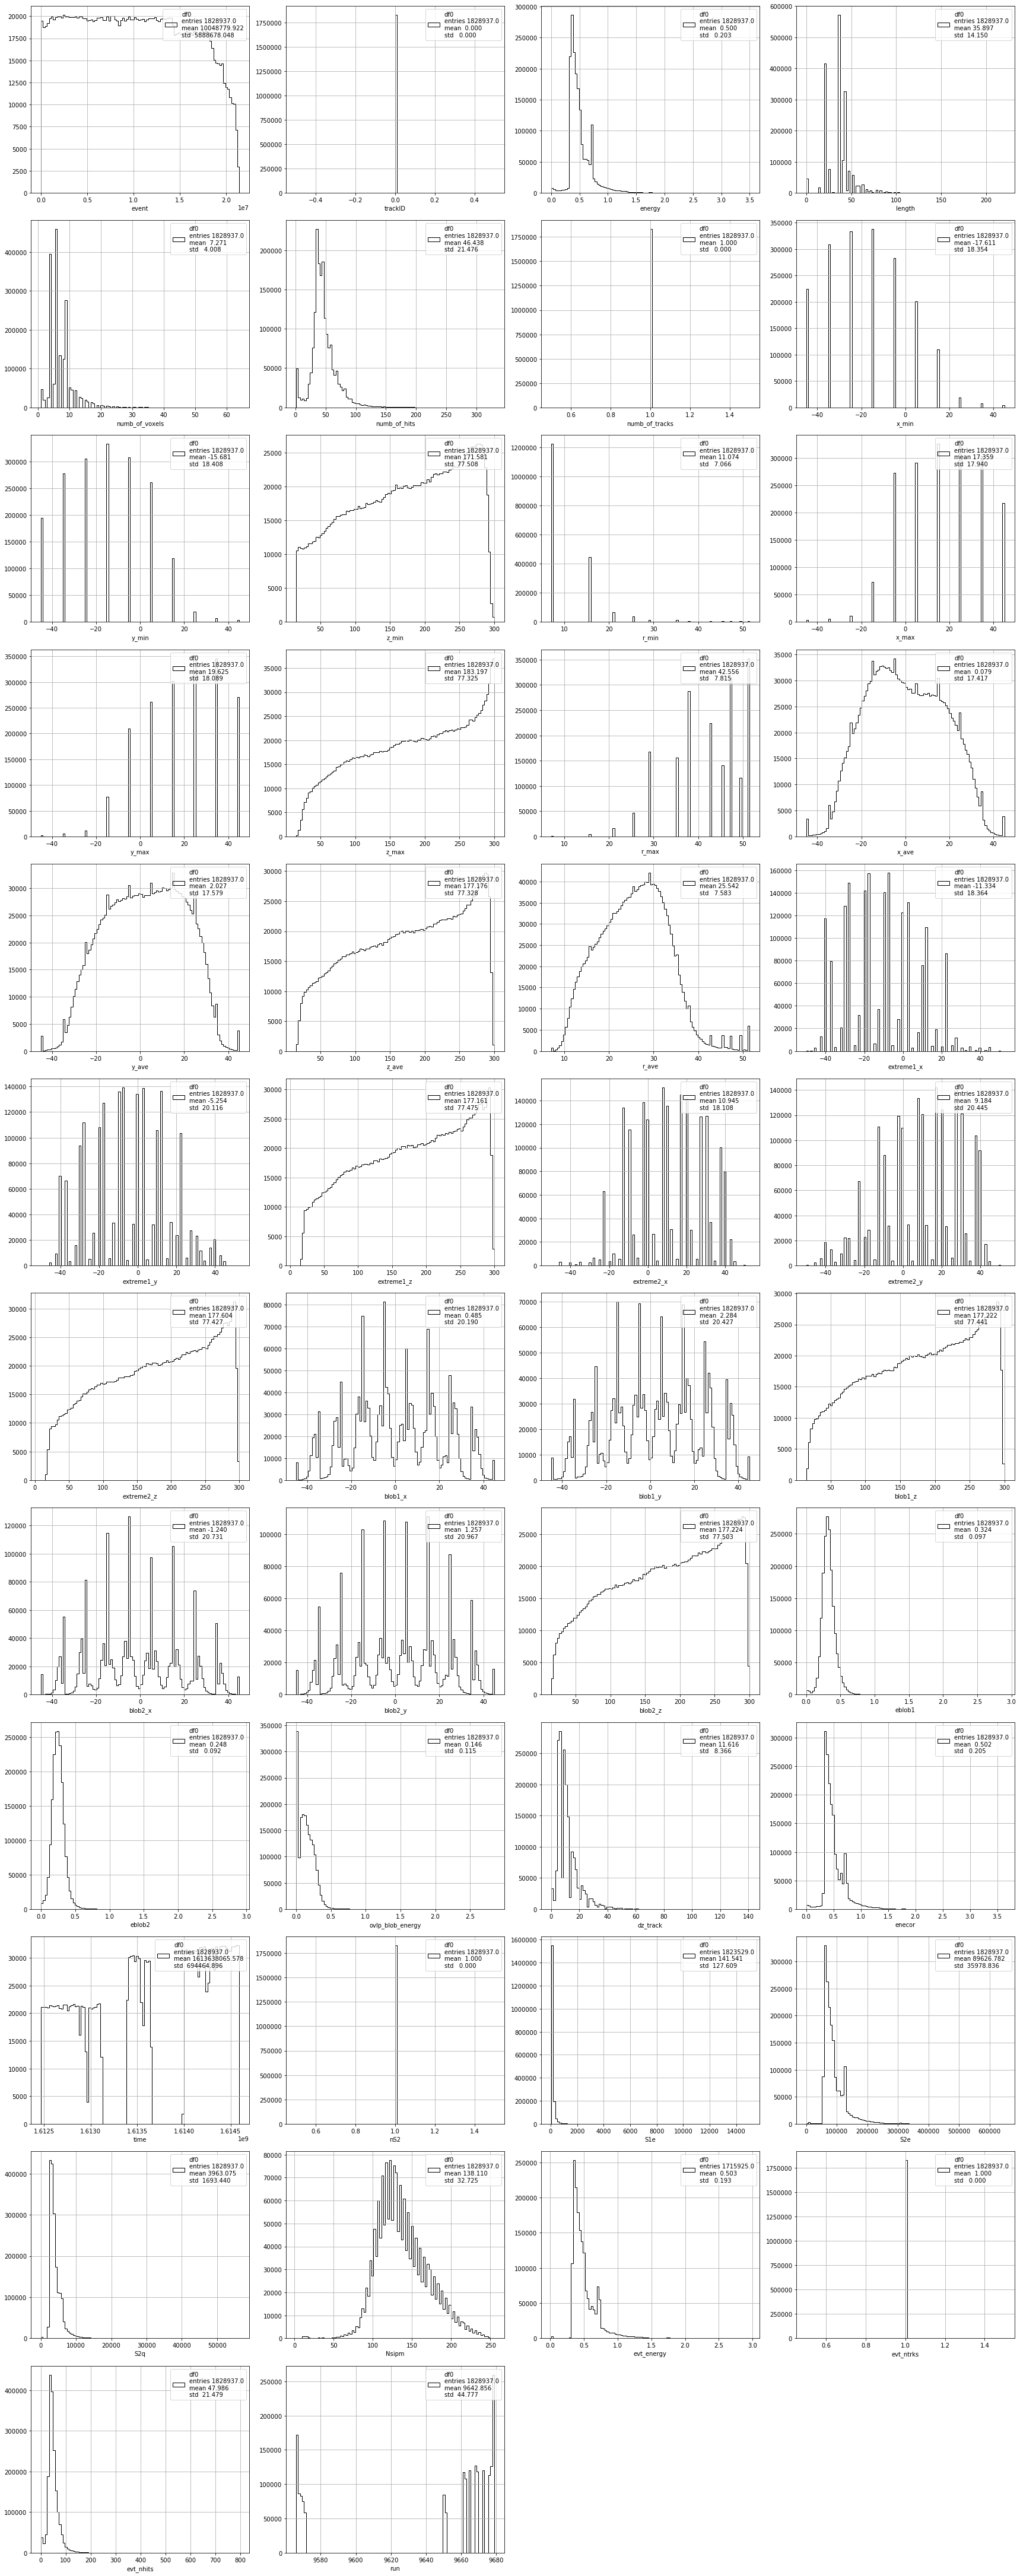

In [6]:
columns = list(dft.columns)
print(columns)
i = columns.index('evt_out_of_map') # problems with plotting, remove from the list to plot
columns.pop(i)
pltext.df_inspect(dft, columns, ncolumns = 4)

### selections and ranges

In [7]:
ranges = {'nS2'            : (1., 1.),
          'evt_out_of_map' : (False, False),
          'numb_of_tracks' : (1., 1.),
          'z_min'          : (15., 300.),
          'z_max'          : (15., 300.),
          'r_max'          : (0.,  55.),
          'energy'         : (0., 3.),
          'energy.cs'      : (0.68, 0.76),
          'energy.ds'      : (1.60, 1.85),
          'energy.ph'      : (2.00, 3.00),
          'dz_track.cs'    : (0., 60.),
          'dz_track.ds'    : (0., 150.)
         }
for key in ranges.keys():
    print(key, ranges[key])

nS2 (1.0, 1.0)
evt_out_of_map (False, False)
numb_of_tracks (1.0, 1.0)
z_min (15.0, 300.0)
z_max (15.0, 300.0)
r_max (0.0, 55.0)
energy (0.0, 3.0)
energy.cs (0.68, 0.76)
energy.ds (1.6, 1.85)
energy.ph (2.0, 3.0)
dz_track.cs (0.0, 60.0)
dz_track.ds (0.0, 150.0)


In [8]:
selections = nsel.Selections(dft, ranges)

In [9]:
selnames    = ('nS2', 'numb_of_tracks', 'z_min', 'z_max', 'r_max')
selections.logical_and(selnames, 'fidutial');

In [10]:
#pltext.df_inspect(dft[selections['fidutial']], columns[:-1], ncolumns = 3)

### Energy 

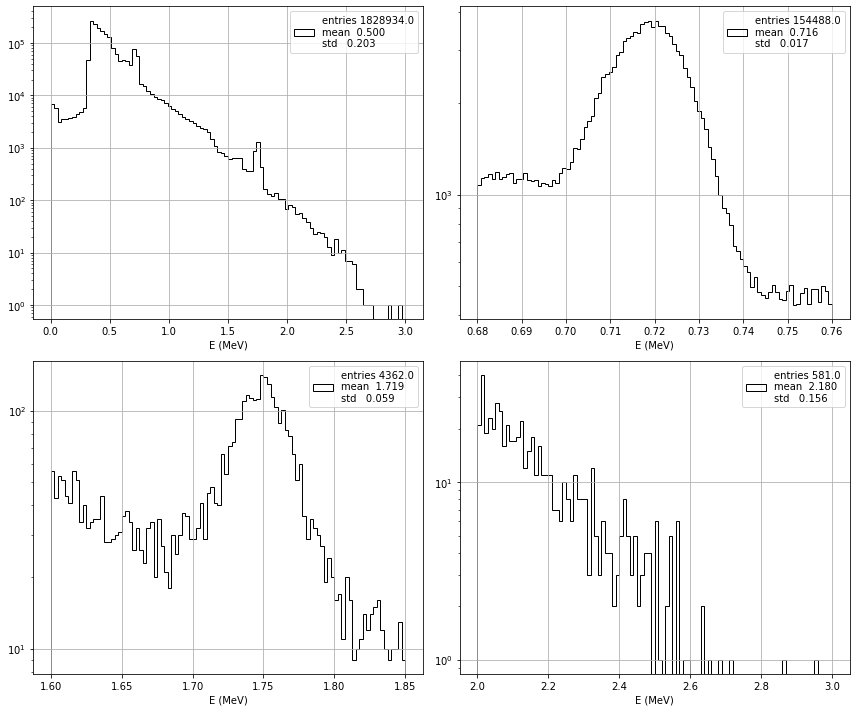

In [11]:
def plt_energies(enes, ranges, bins = 100):

    nplots = len(ranges)

    subplot = pltext.canvas(nplots, 2)
    
    for i in range(nplots):
        subplot( i + 1)
        pltext.hist(enes, bins, range = ranges[i], ylog = True, xylabels = 'E (MeV)'); 
    plt.tight_layout()

sel     = selections['fidutial']
eranges = [ranges[name] for name in ('energy', 'energy.cs', 'energy.ds', 'energy.ph')]
plt_energies(dft.energy[sel], eranges)
#plt_energies(dft.energy)

resolution R =  2.706 +- 0.01443
resolution R =  2.392 +- 0.07166


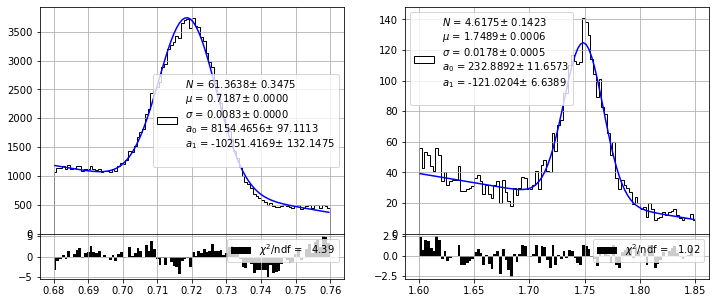

In [12]:
def plt_energy(ename = 'energy'):
    eranges = [ranges[name] for name in ('energy.cs', 'energy.ds')]
    subplot = pltext.canvas(len(eranges))
    for i, erange in enumerate(eranges):
        subplot(i + 1)
        pars = eres.energy_fit(dft[ename].values, 100, range = erange, plot = True)
        print('resolution R = {0:6.3f} +- {1:6.5f}'.format(*pars[-2:]))

plt_energy('energy')

## Delta Z- Effect


In [13]:
def plt_dzeffect(name = 'energy', peak = 'cs', nbins = 10, p0 = None, 
                 dft = dft, ranges = ranges, selections = selections):
    ename   = name       + '.' + peak
    dzname  = 'dz_track' + '.' +  peak
    sel     = selections[ename] & selections[dzname]
    dz, ene = dft[sel]['dz_track'], dft[sel][name]
    p0s     = nbins*[p0,]
    _, _, _, par, _ = eres.dz_effect(dz, ene, nbins = nbins, p0s = p0s, plot = True)
    print('dz-effect : ({0:6.4f}, {1:6.5f})'.format(*par))
    return par

dz-effect : (0.7323, -0.00075)


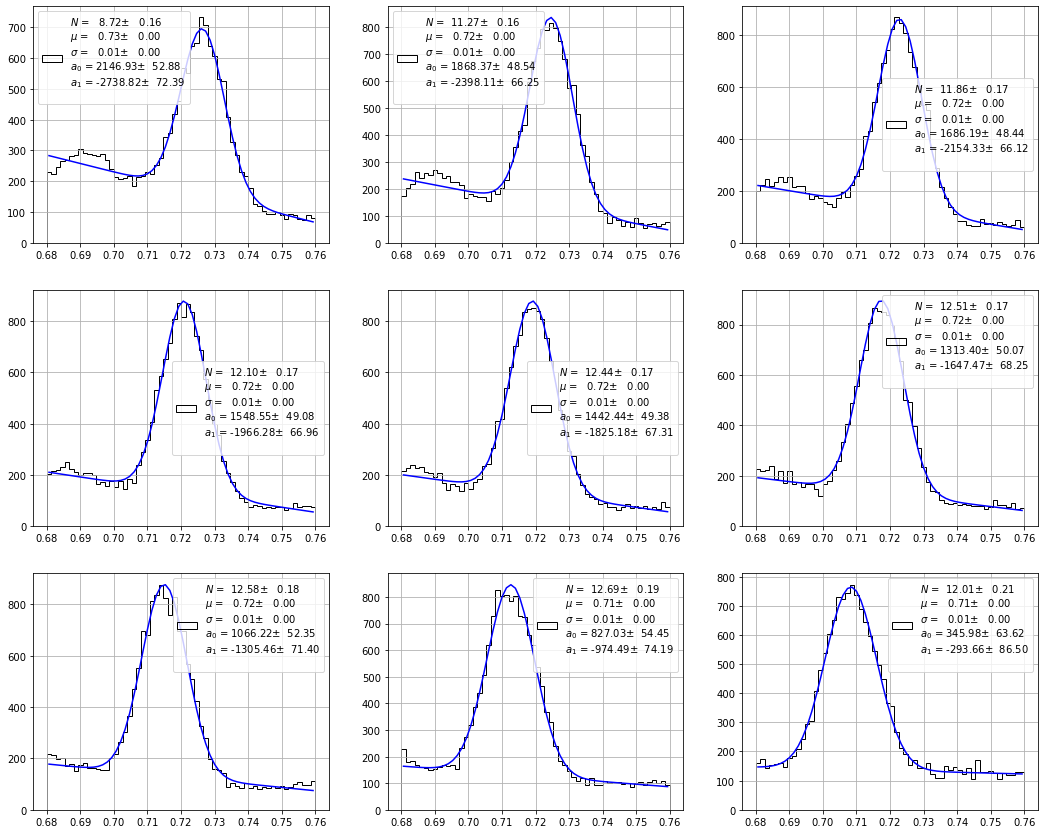

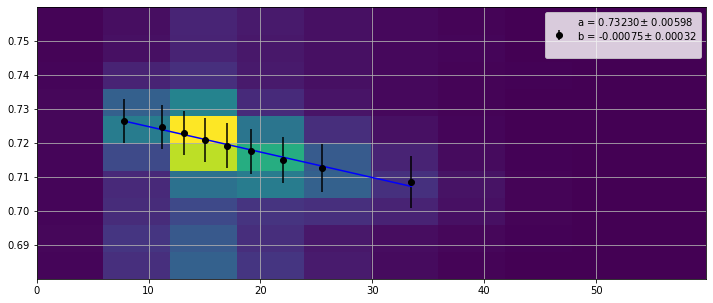

In [14]:
p0 = (10., 0.72, 0.2, 10, -10)
cs_par = plt_dzeffect('energy', 'cs', p0 = p0)

dz-effect : (1.7736, -0.00056)


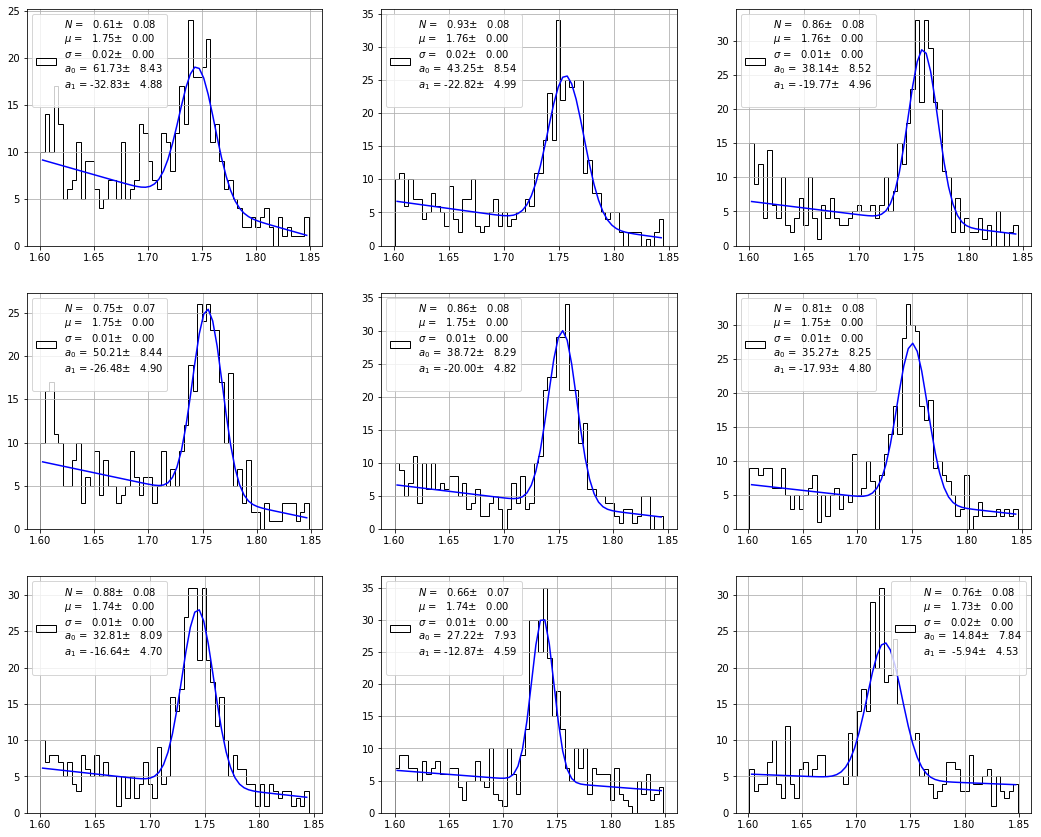

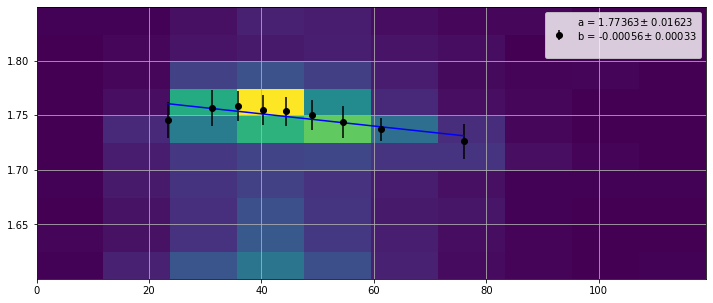

In [15]:
p0 = (10., 1.75, 0.2, 10, -10)
ds_par = plt_dzeffect('energy', 'ds', p0 = p0)

## Energy correction

In [16]:
cor = 'ds'

ds_energy = 2.615 - 2 * 0.511
cs_energy = 0.663
#print(energy_ds)

ene0, slope = cs_par    if cor == 'cs' else ds_par
eneref      = cs_energy if cor == 'cs' else ds_energy
scale = eneref/ene0
alpha = abs(slope)/ene0
scale = 1.

print(scale, alpha, ene0, eneref)

ene, dz = [dft[name].values for name in ('energy', 'dz_track')]
enecor  = eres.dz_energy_correction(ene, dz, alpha, scale)
dft.enecor = np.copy(enecor)

1.0 0.00031509896805984695 1.7736280821170884 1.5930000000000002


In [17]:
for peak in ('cs', 'ds'):
    selections.set_range('enecor.' + peak, ranges['energy.'+peak])

## Energy resolution

resolution R =  2.474 +-  0.012
resolution R =  2.087 +-  0.063


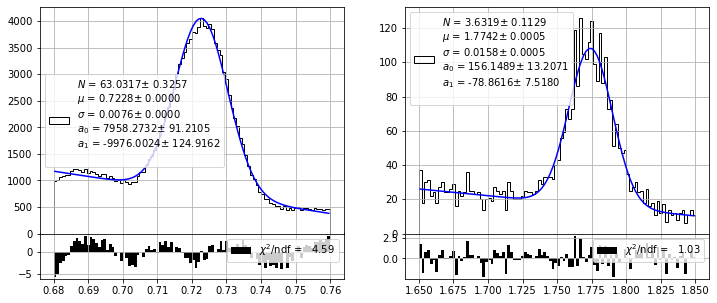

In [18]:
ename   = 'enecor'
eranges = [ranges[name] for name in ('energy.cs', 'energy.ds')]
subplot = pltext.canvas(len(eranges))
for i, erange in enumerate(eranges):
    subplot(i + 1)
    p0 = None if i == 0 else (10., 1.75, 0.2, 10., -10.)
    erange = erange if i == 0 else (1.65, 1.85)
    pars = eres.energy_fit(dft[ename].values, 100, range = erange, p0 = p0, plot = True)
    print('resolution R = {0:6.3f} +- {1:6.3f}'.format(*pars[-2:]))

## Check DZ

dz-effect : (0.7325, -0.00053)


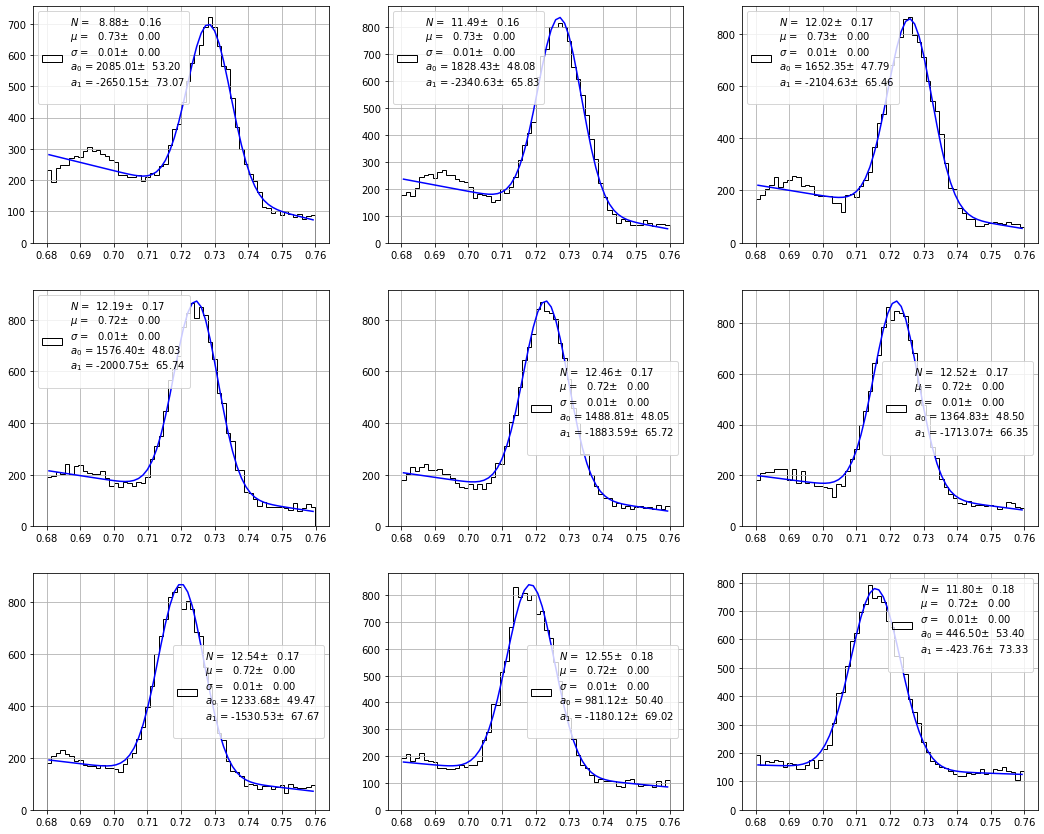

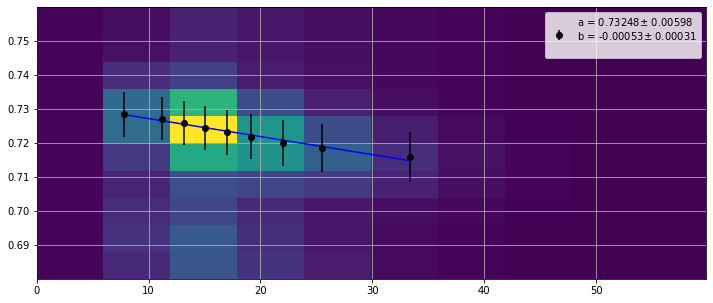

In [19]:
p0 = (10., 0.72, 0.2, 10, -10)
plt_dzeffect('enecor', 'cs', p0 = p0);

dz-effect : (1.7776, -0.00008)


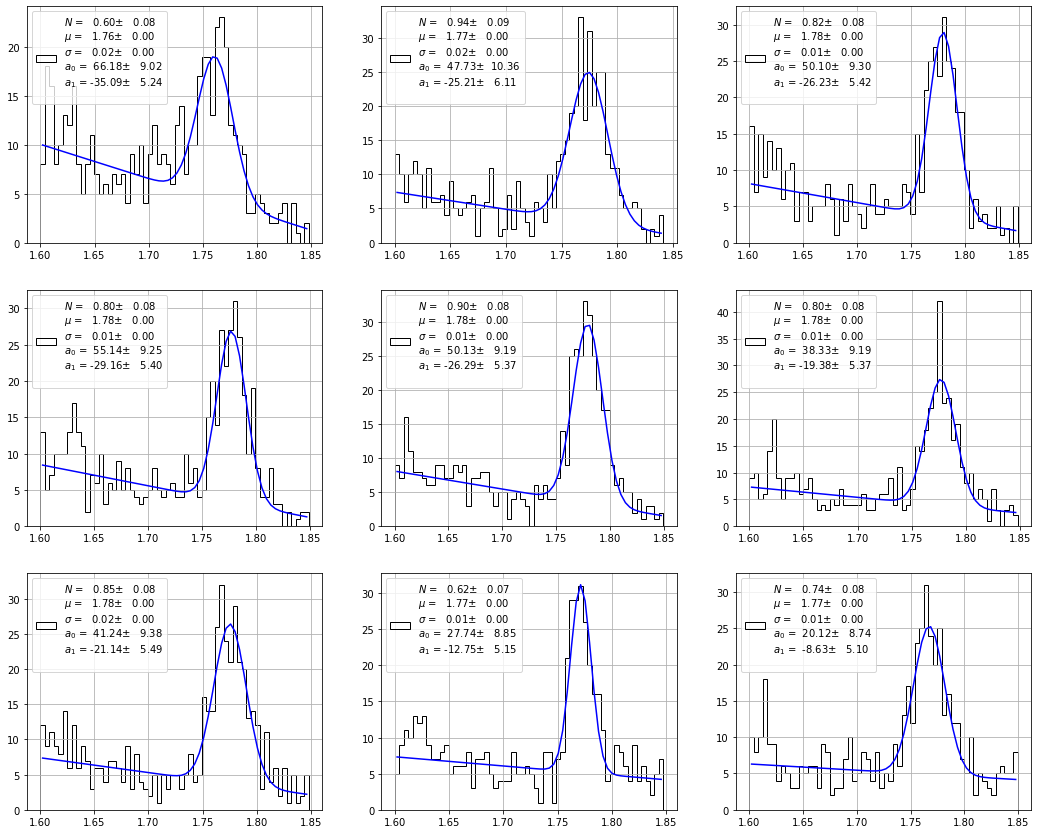

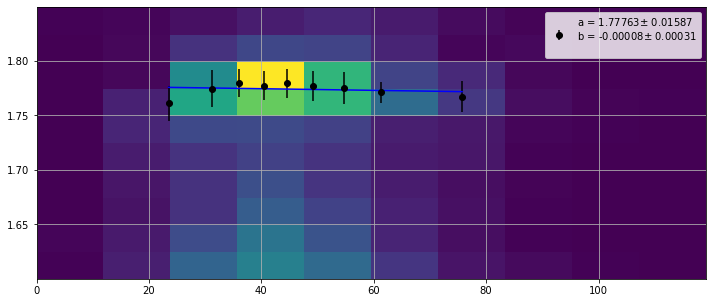

In [20]:
p0 = (10., 1.75, 0.02, 10, -10)
plt_dzeffect('enecor', 'ds', p0 = p0);